In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [5]:
len(dataset)

163

In [6]:
train_ds = dataset.take(130)
len(train_ds)

130

In [7]:
test_ds = dataset.skip(130)
len(test_ds)

33

In [8]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [9]:
test_ds = test_ds.skip(16)
len(test_ds)

17

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(test_ds)

17

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3


130/130 [==============================] - 157s 949ms/step - loss: 0.5835 - accuracy: 0.7452 - val_loss: 0.5292 - val_accuracy: 0.7734
Epoch 2/3
130/130 [==============================] - 99s 762ms/step - loss: 0.4257 - accuracy: 0.8142 - val_loss: 0.3795 - val_accuracy: 0.8574
Epoch 3/3
130/130 [==============================] - 101s 773ms/step - loss: 0.2682 - accuracy: 0.8909 - val_loss: 0.1645 - val_accuracy: 0.9414


In [20]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 23s 239ms/step - loss: 0.2033 - accuracy: 0.9081


first image to predict
actual label: PNEUMONIA
1/1 [==============================] - 1s 1s/step
predicted label: PNEUMONIA


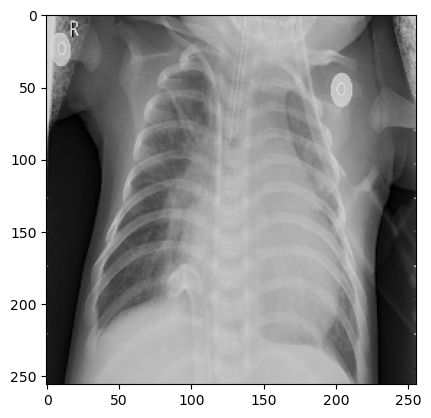

In [21]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[1])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


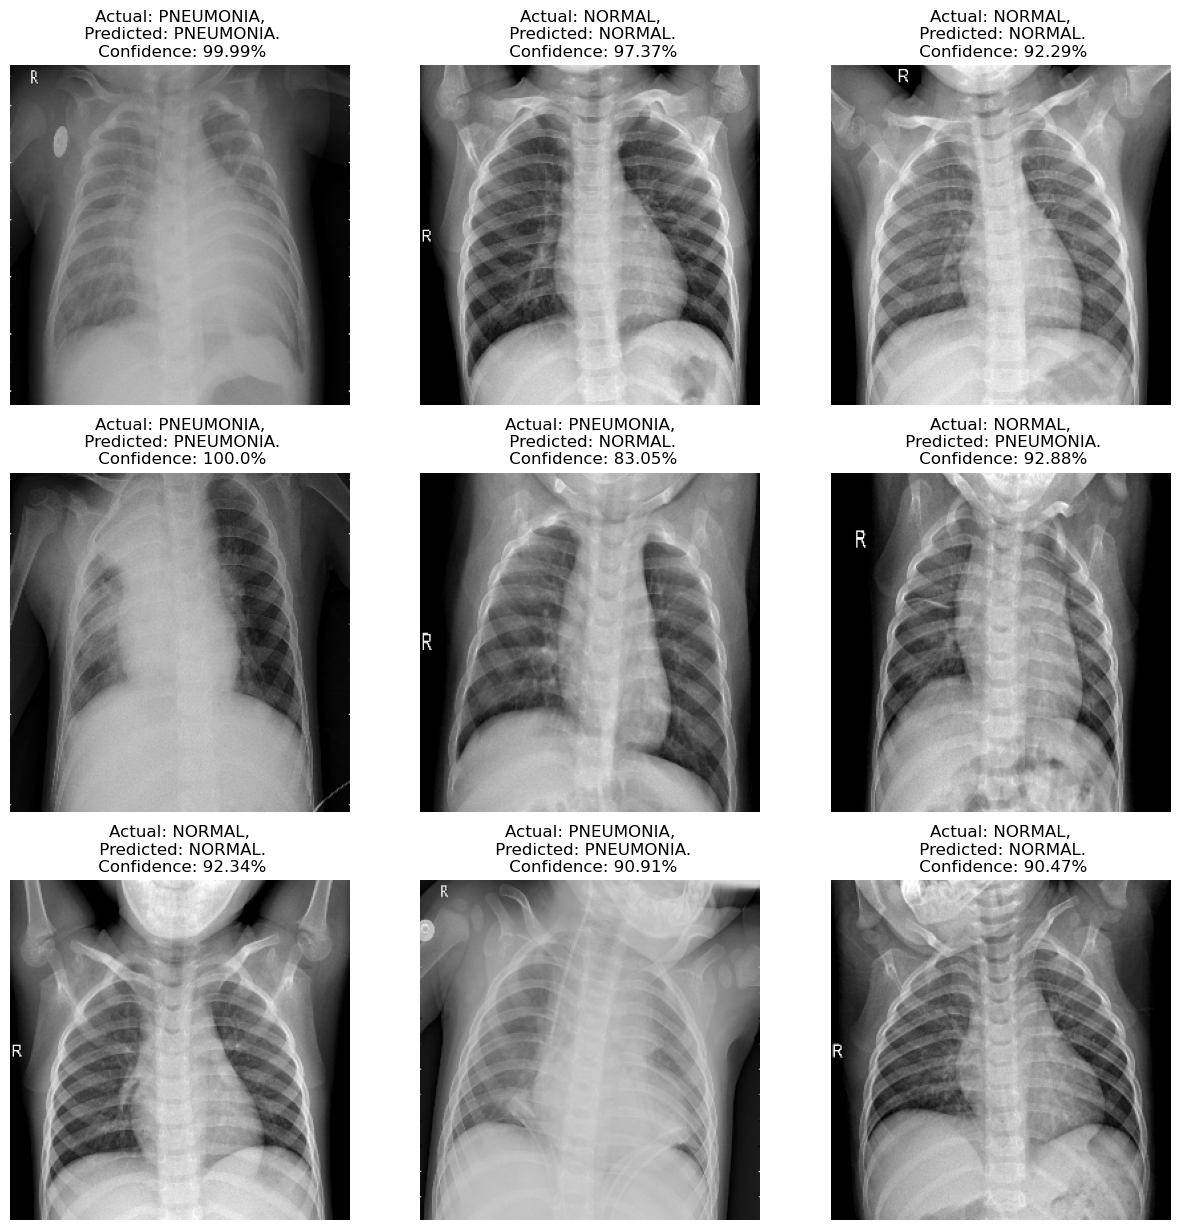

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
model_version = 3
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [27]:

model.save("../saved_models/x_ray.h5")

In [28]:
MODEL = tf.keras.models.load_model("../saved_models/x_ray.h5")

In [30]:
model.predict()

IndexError: tuple index out of range

In [31]:
import PIL.Image

In [49]:
image = cv2.imread('../traning/chest_xray/NORMAL/IM-0115-0001.jpeg')
img_batch = np.expand_dims(np.resize(image,(256,256,3)), 0)

predictions = MODEL.predict(img_batch)

1/1 [==============================] - 0s 195ms/step


In [50]:
predictions

array([[3.567461e-04, 9.996432e-01]], dtype=float32)

In [4]:
import cv2

In [39]:
image.shape

(1858, 2090, 3)

In [46]:
image.resize(196608).reshape(256,256,3)

ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [48]:
np.resize(image,(256,256,3))

array([[[ 22,  22,  22],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [109, 109, 109],
        [111, 111, 111],
        [112, 112, 112]],

       [[112, 112, 112],
        [111, 111, 111],
        [110, 110, 110],
        ...,
        [ 74,  74,  74],
        [ 75,  75,  75],
        [ 74,  74,  74]],

       [[ 75,  75,  75],
        [ 73,  73,  73],
        [ 71,  71,  71],
        ...,
        [186, 186, 186],
        [185, 185, 185],
        [191, 191, 191]],

       ...,

       [[ 94,  94,  94],
        [ 90,  90,  90],
        [ 91,  91,  91],
        ...,
        [105, 105, 105],
        [106, 106, 106],
        [105, 105, 105]],

       [[105, 105, 105],
        [106, 106, 106],
        [106, 106, 106],
        ...,
        [101, 101, 101],
        [101, 101, 101],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [ 99,  99,  99],
        ...,
        [118, 118, 118],
        [117, 117, 117],
        [121, 121, 121]]

In [2]:
MODEL = tf.keras.models.load_model("../saved_models/x_ray.h5")

In [22]:

image = cv2.imread('../traning/chest_xray/PNEUMONIA/person1001_bacteria_2932.jpeg')
IMAGE_SIZE=256
img = tf.keras.preprocessing.image.smart_resize(
    image,
    
    size=(IMAGE_SIZE,IMAGE_SIZE),
   
)
img_batch = np.expand_dims(img, 0)
predictions = MODEL.predict(img_batch)
print(predictions)

1/1 [==============================] - 0s 24ms/step
[[0.07044243 0.92955756]]


In [6]:
import numpy as np

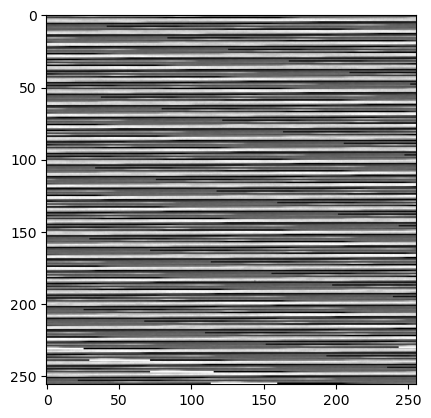

In [8]:
plt.imshow(np.resize(image,(256,256,3)))

In [10]:
predictions

array([[3.567461e-04, 9.996432e-01]], dtype=float32)